# Digital Unpaid Script

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas.io.sql as sqlio
from datetime import date,datetime
import psycopg2 as ps
from helpers import connectors
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
sns.set_style("darkgrid")

# Connect with DWH/CSV

In [2]:
con = connectors.DWHGlovoConnection().create_conn()

# SQL Query

In [3]:
cb_query='''
select distinct o.id                                                                as order_id
              , o.customer_id
              , o.store_address_id
              , courier_id
              , category
              , o.vertical
              , date_trunc('day', o.creation_time)                                  as order_day
              , o.ordering_payment_method
              ,o.payment_status
              , p.payment_status as p_payment_status
              ,final_status
              , o.is_groceries
              , o.purchases_estimated_price
              , o.total_purchase                                                    as total_purchase_euro
              , o.total_purchase - o.purchases_estimated_price                      as price_difference
              , o.balance_discount
               , gtv
                ,  case when country_code in ('CI','UG') then authorization_amount/o.exchange_rate_currency
        else authorization_amount/100/o.exchange_rate_currency end as authorization_euros
              , gtv/o.exchange_rate_currency as gtv_euro,
       nullif(json_extract_path_text(features, 'customer', 'accountAgeInSeconds'), ' ')::int / 60 /
       60                                                                                                          as account_age_hours,
       nullif(json_extract_path_text(features, 'customer', 'accountAgeInDays'),
              ' ')::int                                                                                               accountAgeInDays,
       nullif(json_extract_path_text(features, 'customerNetwork', 'values', 'GRAPH_SIZE_0'),
              ' ')::bigint                                                                                            graph_size,
       nullif(json_extract_path_text(features, 'ml', 'ml_uch', 'score'),
              ' ')::bigint                                                                                            cash_score,
       json_extract_path_text(features, 'customer', 'name')                                                        as customer_name,
       json_extract_path_text(features, 'ravelin', 'score')                                                        as ravelin_score,
       json_extract_path_text(features, 'ravelin', 'source')                                                       as ravelin_source,
       json_extract_path_text(features, 'ravelin', 'action')                                                       as ravelin_action,
       json_extract_path_text(features, 'customer', 'email')                                                       as email,
       json_extract_path_text(features, 'customer', 'phoneNumber')                                                 as phone,
       nullif(json_extract_path_text(features, 'customer', 'accountAgeInSeconds'),
              ' ')::int                                                                                               account_age_seconds,
       json_extract_path_text(features, 'store', 'id')                                                             as store_id,
       json_extract_path_text(features, 'order', 'deliveryPoint',
                              'h3AddressResolution9')                                                              as delivery_point,
       json_extract_path_text(features, 'order', 'pickupPoint',
                              'h3AddressResolution9')                                                              as pickup_point,
       json_extract_path_text(features, 'device', 'appVersion')                                                    as appversion,
       json_extract_path_text(features, 'device', 'model')                                                         as device_model,
       json_extract_path_text(features, 'device', 'osVersion')                                                     as device_osVersion,
       json_extract_path_text(features, 'device', 'ipAddress')                                                     as device_ip,
       json_extract_path_text(features, 'device', 'os')                                                            as device_os,
       json_extract_path_text(features, 'device', 'type')                                                          as device_type,
       json_extract_path_text(features, 'payment_method', 'cardBin')                                               as BIN,
       json_extract_path_text(features, 'payment_method', 'country')                                               as cc_country,
       json_extract_path_text(features, 'payment_method', 'cardProvider')                                          as card_provider,
       json_extract_path_text(features, 'store', 'categoryId')                                                     as store_category,
       json_extract_path_text(features, 'store', 'name')                                                           as store_name,
       json_extract_path_text(features, 'order', 'type')                                                           as order_type,
       json_extract_path_text(features, 'customer', 'paymentProfile',
                              'activeCount')                                                                       as payment_activecount,
       json_extract_path_text(features, 'customer', 'paymentProfile',
                              'failedCount')                                                                       as payment_failedcount,
       json_extract_path_text(features, 'customer', 'paymentProfile',
                              'count')                                                                             as payment_count,
       json_extract_path_text(features, 'customer', 'paidOrdersCount')                                             as paid_orders,
       json_extract_path_text(features, 'customer',
                              'ordersCountInLast30Days')                                                           as orders_30days,
       nullif(json_extract_path_text(features, 'customer', 'finishedOrdersCount'),
              ' ')::int                                                                                            as foc,
       nullif(json_extract_path_text(features, 'payment_method', 'ageInSeconds'),
              ' ')::int                                                                                            AS card_age,
       json_extract_path_text(features, 'payment_method', 'creationTime')                                          AS card_age_creation,
       json_extract_path_text(features, 'customer', 'paymentProfile',
                              'distinctCountries')                                                                 AS distinct_countries,
       json_extract_path_text(features, 'customer', 'riskPhoneSpendAndRefundInPeriod',
                              'spendAmountInLast30Days')                                                           AS spent_30d,
       json_extract_path_text(features, 'customer', 'riskPhoneSpendAndRefundInPeriod',
                              'spendAmountInLast90Days')                                                           AS spent_90d,
       json_extract_path_text(features, 'customer', 'riskPhoneSpendAndRefundInPeriod',
                              'refundAmountInLast30Days')                                                          AS refund_30d,
       json_extract_path_text(features, 'customer', 'riskPhoneSpendAndRefundInPeriod',
                              'refundAmountInLast90Days')                                                          AS refund_90d,
       json_extract_path_text(features, 'customer',
                              'ordersCountInLast90Days')                                                           AS order_count_90day,
       json_extract_path_text(features, 'customer',
                              'ordersCountInLast90Days')                                                           AS order_count_30day,
       json_extract_path_text(features, 'customer', 'ordersCountInLast7Days')                                      AS order_count_7day,
       nullif(json_extract_path_text(features, 'customer', 'deliveredOrdersCount'),
              ' ')::int                                                                                            AS delivered_orders,
       json_extract_path_text(features, 'promotion', 'promotionDescription')                                       AS promotion_description,

       json_extract_path_text(features, 'customer', 'paymentProfile',
                              'declineErrors')                                                                     AS decline_errors,

     SUBSTRING([email], CHARINDEX('@', [email]) + 1,
                 LEN([email]))                                                                                     AS email_domain


from orders o
left join payments p
on o.id=p.order_id
left join checkout_order co on co.order_id = o.id
         left join risk_feature_snapshots rfs on json_extract_path_text(features, 'order', 'checkoutId') =
                                                 cast(co.checkout_id as text)



where 1 = 1
  and o.creation_time >= current_date-60
  and o.ordering_payment_method != 'CASH'
  and country_code='GE'
  --and category='QUIERO'
  --AND foc=0
  --and  o.final_status in ('CanceledStatus')

  --and o.payment_status = 'NOT_PAID'
and p.payment_status = 'NOT_PAID'
and o.final_status in ('CanceledStatus', 'DeliveredStatus')
and o.ordering_payment_method !='BANK_TRANSFER'
----and o.store_address_id='537457'
---and device_model='SM-A505FN'
and o.store_address_id not in ('211113','436828')


'''

In [361]:
df = pd.read_sql(cb_query, con)
df

NameError: name 'cb_query' is not defined

In [449]:
##Test
df0=pd.read_csv('ESUnpaid9.25-11.10.csv')
df=df0
df

,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain
0,504010108,340845,NaN,15411286.0,QUIERO,QUIERO,2022-11-05 0:00:00,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.00,710.00,710.00,0.0,719.59,35.0,719.59,50203.0,2091.0,26.0,NaN,Paula Adiego,16.0,RAVELIN,ALLOW,paulaadiegoberdejo1@gmail.com,3.464036e+10,180734019.0,NaN,8939708d1c7ffff,NaN,5.188.1,samsung sm-a137f,12,91.116.33.97,ANDROID,Mobile,491846.0,ES,Visa,NaN,NaN,QUIERO,8.0,0.0,9.0,80.0,12.0,124.0,32445672.0,1.635191e+12,"[null,""ES""]",30554.0,80489.0,0.0,3580.0,24.0,24.0,NaN,107.0,NaN,{},gmail.com
1,499281566,134781181,454261.0,124142709.0,REGALO,WALL - Partner,2022-10-28 0:00:00,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,False,18.99,547.99,529.00,2.0,547.98,17.0,547.98,0.0,0.0,NaN,NaN,Denus,87.0,RAVELIN,ALLOW,bogepog856@ilusale.com,NaN,743.0,300608.0,89395401e73ffff,893954013cfffff,7.85.0,iPhone12Mini,16.0.3,88.17.10.171,IOS,Mobile,NaN,NaN,NaN,22.0,MediaMarkt,STORE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666967e+12,[],0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,ES MGM Standard Q3 2022,{},ilusale.com
2,489012549,89731319,149382.0,91456386.0,SUPER-MARKET,WALL - Partner,2022-10-10 0:00:00,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,True,27.55,541.51,513.96,0.0,545.00,31.0,545.00,7578.0,315.0,19.0,NaN,jeremymancheno1@gmail.com,19.0,RULE,REVIEW,jeremymancheno1@gmail.com,3.464022e+10,27282525.0,77237.0,89390ca9c87ffff,89390ca827bffff,5.185.0,xiaomi 2201116sg,11,90.94.93.79,ANDROID,Mobile,535120.0,ES,MasterCard,4.0,Carrefour,STORE,2.0,0.0,2.0,0.0,0.0,2.0,38.0,1.665413e+12,"[""ES""]",0.0,1349.0,0.0,0.0,1.0,1.0,NaN,2.0,NaN,{},gmail.com
3,481272903,1019975,460710.0,49060058.0,SUPER-MARKET,WALL - Partner,2022-09-27 0:00:00,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,True,5.20,420.00,414.80,0.0,425.49,12.0,425.49,43146.0,1797.0,15.0,NaN,Yasmina Zahira Fresneda Sastre,9.0,RAVELIN,ALLOW,sandra_1988_8@hotmail.com,3.463186e+10,155328981.0,306000.0,89394477247ffff,89394477253ffff,5.183.0,xiaomi m2003j15sc,11,83.42.0.64,ANDROID,Mobile,558566.0,ES,MasterCard,4.0,Ametller Origen,STORE,3.0,1.0,3.0,52.0,4.0,67.0,927088.0,1.663350e+12,"[""ES""]",14788.0,88540.0,0.0,0.0,21.0,21.0,NaN,64.0,NaN,"{""gateway.declined"":1}",hotmail.com
4,499161579,85482303,432128.0,131921642.0,SUPER-MARKET,WALL - Partner,2022-10-28 0:00:00,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,True,30.49,282.00,251.51,0.0,283.99,32.0,283.99,8920.0,371.0,8.0,NaN,Nahia Rodriguez,37.0,RAVELIN,ALLOW,2mcrjfccnk@privaterelay.appleid.com,3.466243e+10,32115071.0,170932.0,8939182cbc7ffff,89391b96487ffff,7.85.0,iPhone12Pro,16.0.2,84.125.101.62,IOS,Mobile,553108.0,ES,MasterCard,4.0,Carrefour,STORE,2.0,0.0,2.0,0.0,2.0,6.0,17170556.0,1.649787e+12,"[""ES""]",2869.0,2869.0,0.0,0.0,2.0,2.0,NaN,6.0,NaN,{},privaterelay.appleid.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,491007300,126415939,83869.0,72341940.0,SUPER-MARKET,WALL - Partner,2022-10-14 0:00:00,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,True,0.00

# Digital Unpaid Trend

In [450]:
df200=pd.to_datetime(df['order_day']).nlargest(n=1)-pd.DateOffset(days = 15)

df2=df.loc[(pd.to_datetime(df['order_day'])>df200.reset_index().loc[0,'order_day'])]

df['price_change%']=(df['gtv_euro']-df['authorization_euros'])/df['authorization_euros']

In [451]:
df['order_day'] = pd.to_datetime(df['order_day'])
df2['order_day']=pd.to_datetime(df2['order_day']).dt.date
df['order_week'] = df['order_day'].dt.isocalendar().week
df['order_day_int'] = df['order_day'].fillna(0).astype(int)
df['order_week'] = df['order_week'].fillna(0).astype(int)
df = df[df['order_week'] != 0].reset_index()

unique = df.groupby('order_week').nunique().reset_index()
sums = df.groupby('order_week').sum().reset_index()

unique1 = df2.groupby('order_day').nunique().reset_index()
sums1 = df2.groupby('order_day').sum().reset_index()


/var/folders/6y/qzgdpb415rq2vz6jdph2xgg80000gp/T/ipykernel_70546/3226126456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['order_day']=pd.to_datetime(df2['order_day']).dt.date


## Last 15 days Unpaid Trend

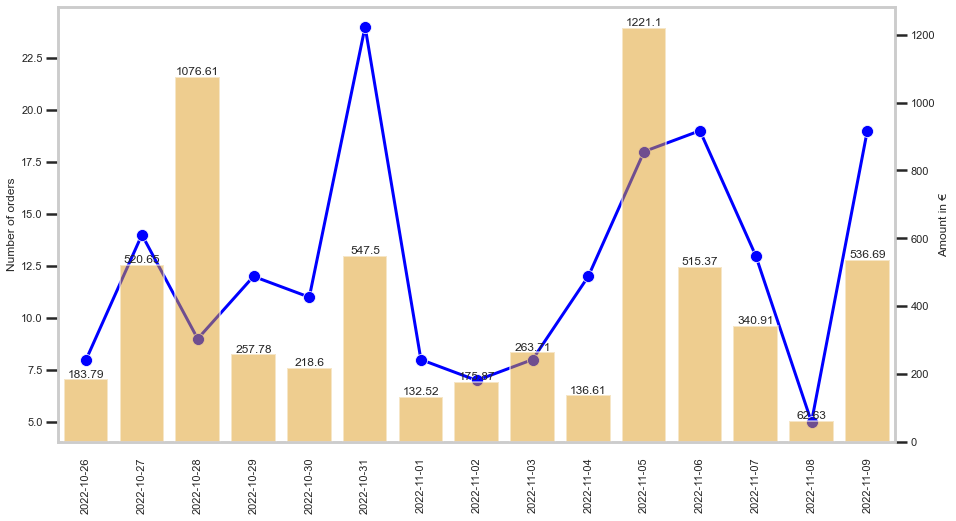

In [452]:


fig, ax1 = plt.subplots(figsize=(15,8))

plt.xticks(rotation=90)
ax2 = plt.twinx()
ax1.set_ylabel(r"Number of orders")

    
ax2.grid(False)
ax1.grid(False)
sns.lineplot(data=unique1['order_id'], color="blue", marker='o', sort = False, ax=ax1)
sns.barplot(data=sums1, x='order_day', y='gtv_euro',color="orange", ax=ax2, alpha=0.5,errwidth=0).set_ylabel(r"Amount in €")


_=ax2.bar_label(ax2.containers[0])



## Last 7 Weeks Unpaid Trend

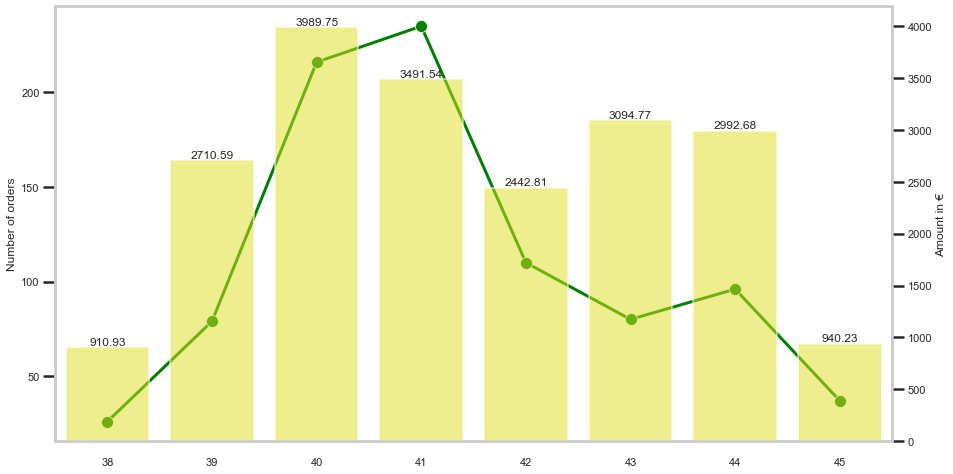

In [453]:
fig, ax1 = plt.subplots(figsize=(15,8))
plt.xticks(range(df['order_week'].max(), df['order_week'].min()));
ax2 = plt.twinx()
ax1.set_ylabel(r"Number of orders")
ax2.grid(False)
ax1.grid(False)
sns.lineplot(data=unique['order_id'], color="green", marker='o', sort = False, ax=ax1)
sns.barplot(data=sums, x='order_week', y='gtv_euro', color="yellow", ax=ax2, alpha=0.5).set_ylabel(r"Amount in €")
_=ax2.bar_label(ax2.containers[0])

# Payment Method Trend

<AxesSubplot:xlabel='order_week', ylabel='gtv_euro'>

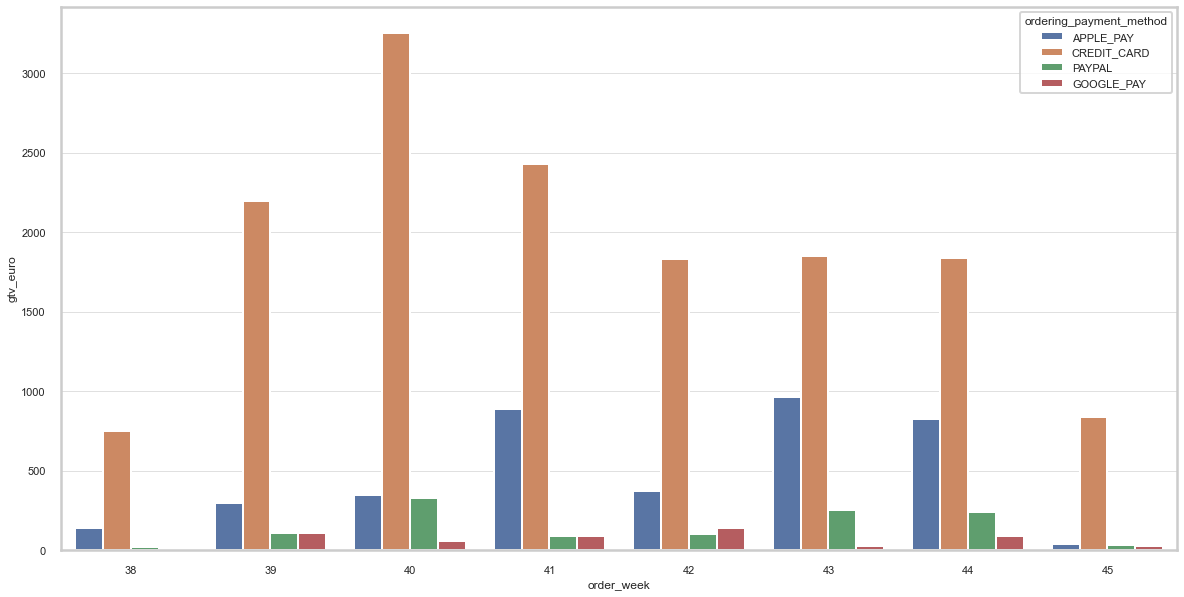

In [454]:
payment = df.groupby(['order_week', 'ordering_payment_method']).sum().reset_index()
sns.barplot(data=payment, x='order_week', y='gtv_euro', hue='ordering_payment_method')

# Category Trend

<AxesSubplot:xlabel='order_week', ylabel='gtv_euro'>

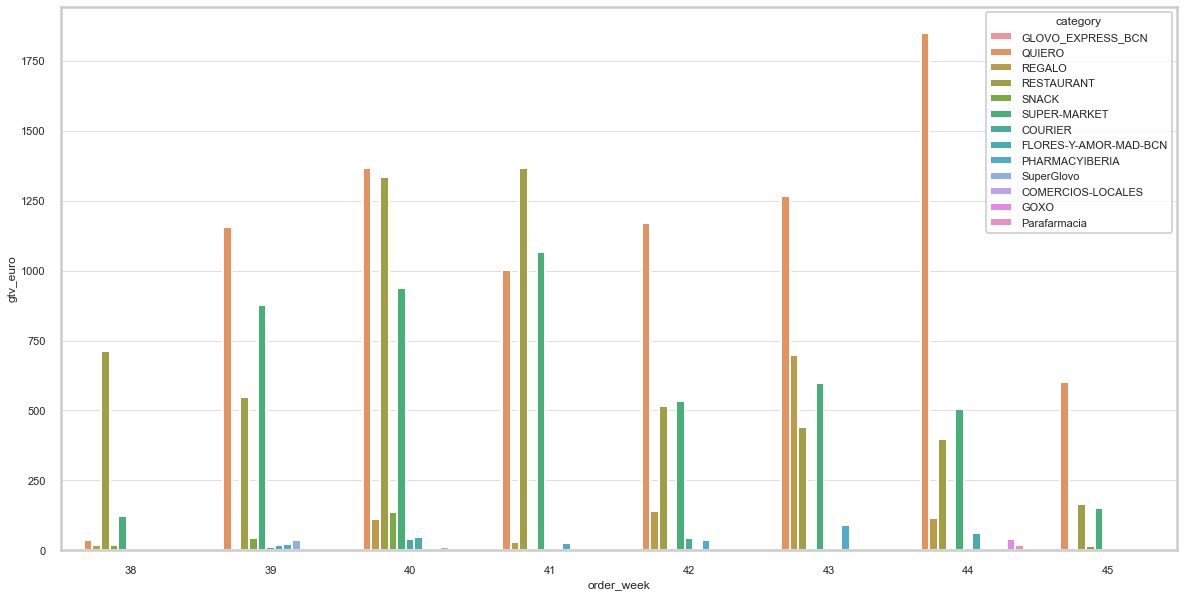

In [455]:
category = df.groupby(['order_week', 'category']).sum().reset_index()
sns.barplot(data=category, x='order_week', y='gtv_euro', hue='category')

# Customer Age Trend

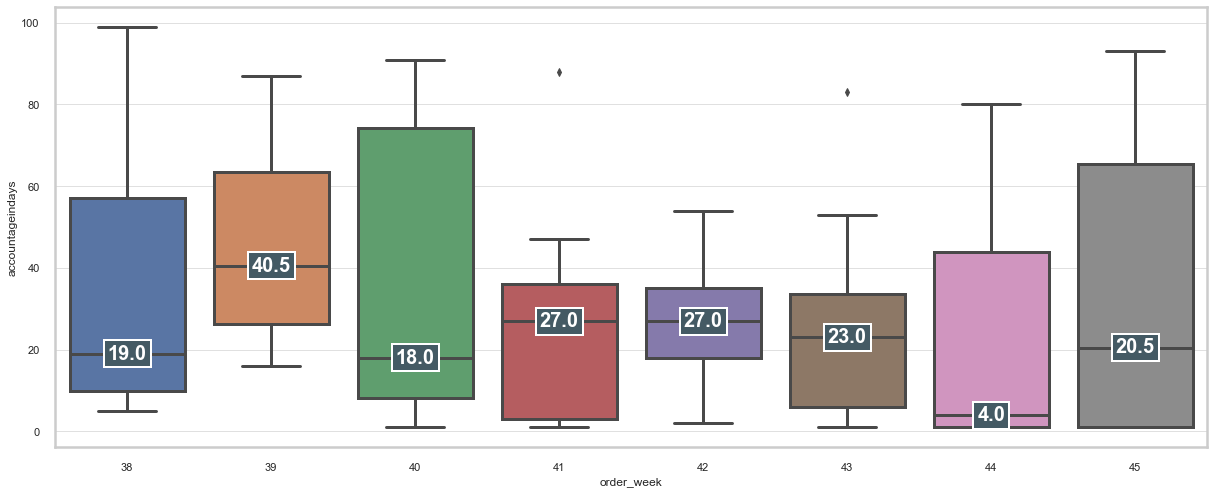

In [456]:

box_plot = sns.boxplot(x='order_week', y='accountageindays', data=df[(df['accountageindays'].between(1, 100)) ])

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=20,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout(pad=10)

# Order_Count_90 Days Trend

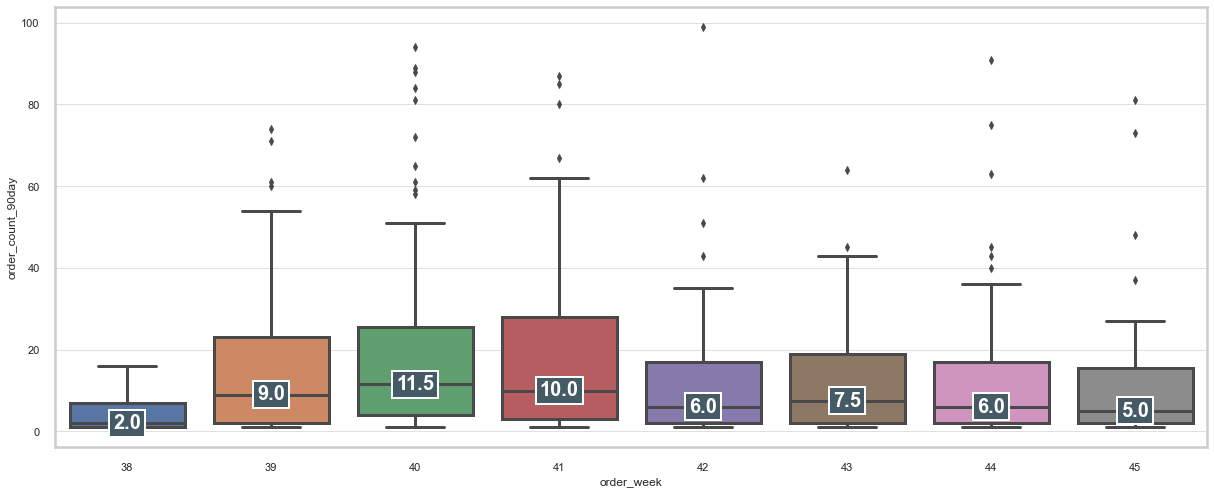

In [457]:
##sns.boxplot(x='order_week', y='order_count_90day',data=df[(df['order_count_90day'].between(1, 100)) ])


box_plot = sns.boxplot(x='order_week', y='order_count_90day', data=df[(df['order_count_90day'].between(1, 100)) ])


ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=20,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout(pad=10)

# Ravelin Action Trend

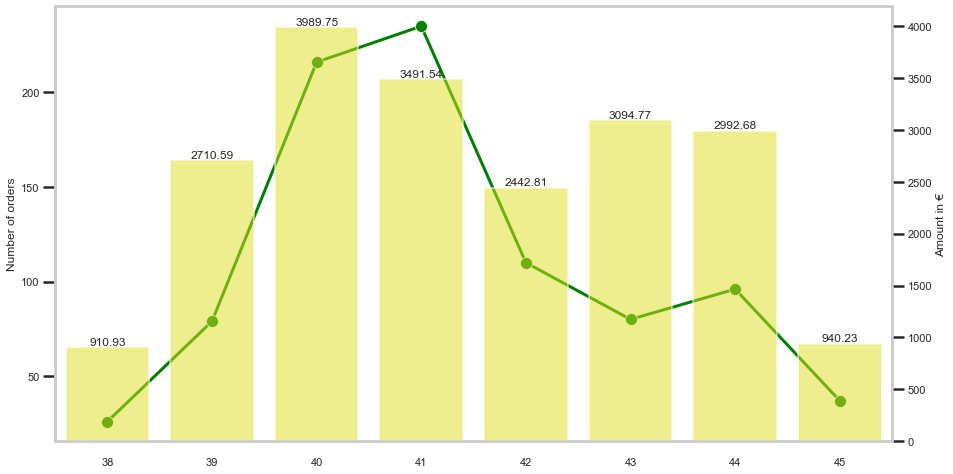

In [458]:
fig, ax1 = plt.subplots(figsize=(15,8))
plt.xticks(range(df['order_week'].max(), df['order_week'].min()));
ax2 = plt.twinx()
ax1.set_ylabel(r"Number of orders")
ax2.grid(False)
ax1.grid(False)
sns.lineplot(data=unique['order_id'], color="green", marker='o', sort = False, ax=ax1)
sns.barplot(data=sums, x='order_week', y='gtv_euro', color="yellow", ax=ax2, alpha=0.5).set_ylabel(r"Amount in €")
_=ax2.bar_label(ax2.containers[0])

## Ravelin Action Trend (Euros)

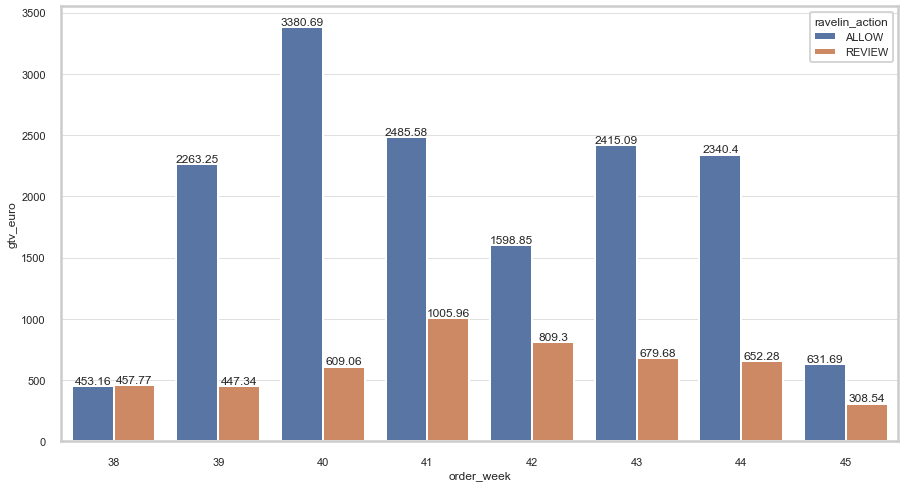

In [459]:
fig,ax= plt.subplots(figsize=(15,8))
category = df.groupby(['order_week', 'ravelin_action']).sum().reset_index()

##ax1.grid(False)
sns.barplot(data=category, x='order_week', y='gtv_euro',hue='ravelin_action')

_=ax.bar_label(ax.containers[0])
_=ax.bar_label(ax.containers[1])


 ## Ravelin Action Trend (Total orders numbers)

Text(0, 0.5, 'Orders number')

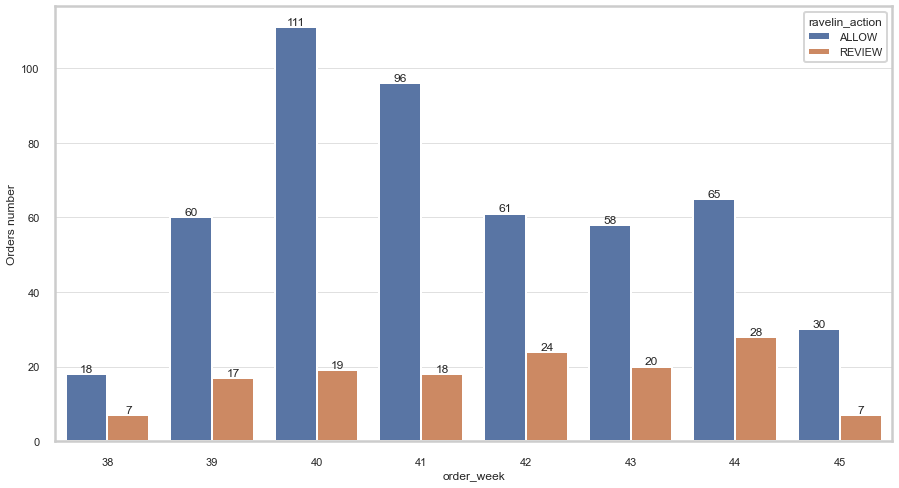

In [460]:
fig,ax= plt.subplots(figsize=(15,8))
category = df.groupby(['order_week', 'ravelin_action']).count().reset_index()
sns.barplot(data=category, x='order_week', y='gtv_euro', hue='ravelin_action')

_=ax.bar_label(ax.containers[0])
_=ax.bar_label(ax.containers[1])
plt.ylabel('Orders number')

# Ravelin scores distribution over time

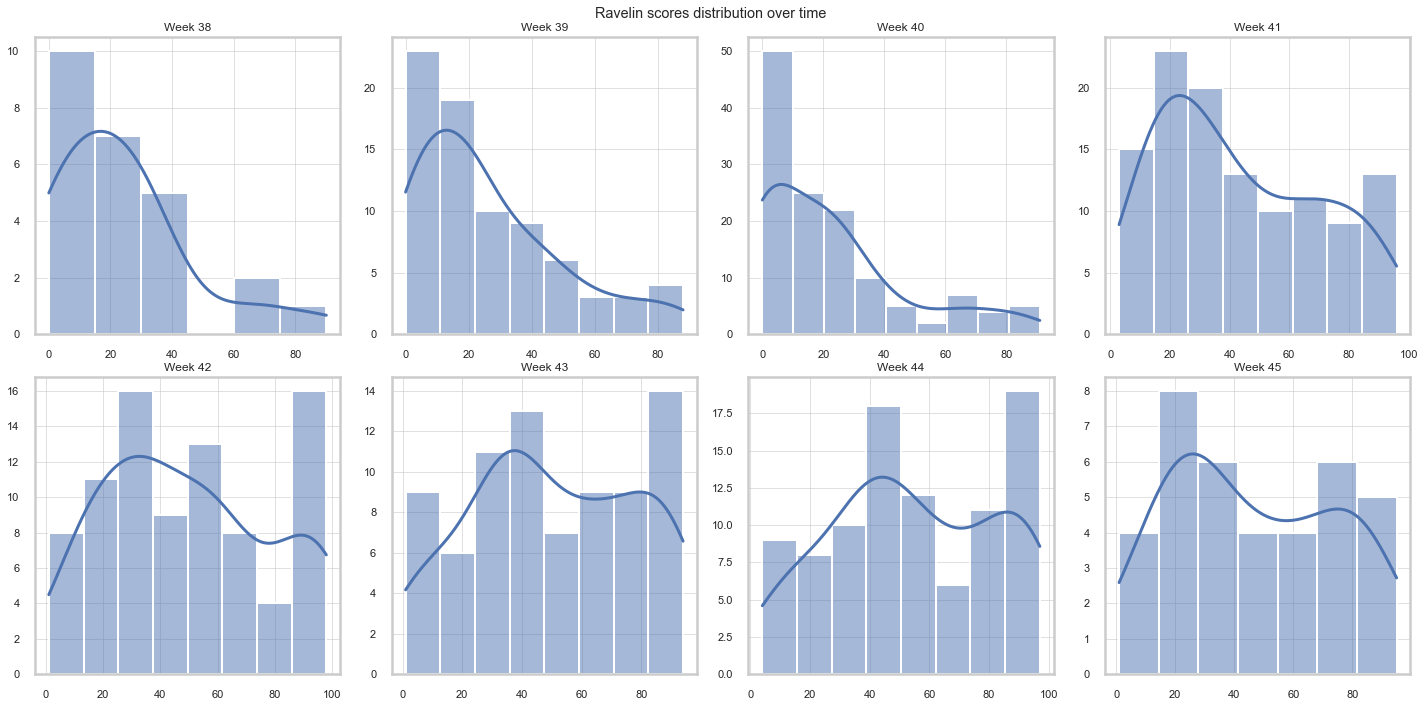

In [463]:
fig, axes = plt.subplots(ncols=4, nrows=2,)
fig.suptitle('Ravelin scores distribution over time')
fig.tight_layout()

for i, ax in zip(range(df['order_week'].max()-7, df['order_week'].max()+1), axes.flat):
    sns.histplot(df[df['order_week'] == i]['ravelin_score'], ax=ax, kde=True).set(title=f'Week {i}', xlabel=None, ylabel=None)
plt.show()

# Top 20 digital unpaid orders in last 15 days

In [464]:
df200=pd.to_datetime(df['order_day']).nlargest(n=1)-pd.DateOffset(days = 15)

df2=df.loc[(pd.to_datetime(df['order_day'])>df200.reset_index().loc[0,'order_day'])]

df2.nlargest(n=20, columns=['gtv_euro'])

,index,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain,price_change%,order_week,order_day_int
0,0,504010108,340845,NaN,15411286.0,QUIERO,QUIERO,2022-11-05,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.00,710.00,710.00,0.0,719.59,35.0,719.59,50203.0,2091.0,26.0,NaN,Paula Adiego,16.0,RAVELIN,ALLOW,paulaadiegoberdejo1@gmail.com,3.464036e+10,180734019.0,NaN,8939708d1c7ffff,NaN,5.188.1,samsung sm-a137f,12,91.116.33.97,ANDROID,Mobile,491846.0,ES,Visa,NaN,NaN,QUIERO,8.0,0.0,9.0,80.0,12.0,124.0,3.244567e+07,1.635191e+12,"[null,""ES""]",30554.0,80489.0,0.0,3580.0,24.0,24.0,NaN,107.0,NaN,{},gmail.com,19.559714,44,1667606400000000000
1,1,499281566,134781181,454261.0,124142709.0,REGALO,WALL - Partner,2022-10-28,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,False,18.99,547.99,529.00,2.0,547.98,17.0,547.98,0.0,0.0,NaN,NaN,Denus,87.0,RAVELIN,ALLOW,bogepog856@ilusale.com,NaN,743.0,300608.0,89395401e73ffff,893954013cfffff,7.85.0,iPhone12Mini,16.0.3,88.17.10.171,IOS,Mobile,NaN,NaN,NaN,22.0,MediaMarkt,STORE,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.666967e+12,[],0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,ES MGM Standard Q3 2022,{},ilusale.com,31.234118,43,1666915200000000000
4,4,499161579,85482303,432128.0,131921642.0,SUPER-MARKET,WALL - Partner,2022-10-28,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,True,30.49,282.00,251.51,0.0,283.99,32.0,283.99,8920.0,371.0,8.0,NaN,Nahia Rodriguez,37.0,RAVELIN,ALLOW,2mcrjfccnk@privaterelay.appleid.com,3.466243e+10,32115071.0,170932.0,8939182cbc7ffff,89391b96487ffff,7.85.0,iPhone12Pro,16.0.2,84.125.101.62,IOS,Mobile,553108.0,ES,MasterCard,4.0,Carrefour,STORE,2.0,0.0,2.0,0.0,2.0,6.0,1.717056e+07,1.649787e+12,"[""ES""]",2869.0,2869.0,0.0,0.0,2.0,2.0,NaN,6.0,NaN,{},privaterelay.appleid.com,7.874688,43,1666915200000000000
13,13,498710096,134725060,NaN,47338912.0,QUIERO,QUIERO,2022-10-27,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.00,139.00,139.00,0.0,140.39,14.0,140.39,0.0,0.0,NaN,NaN,David,92.0,RAVELIN,REVIEW,david639ar22f@gmail.com,NaN,2419.0,NaN,89390cbb36fffff,89390cbb223ffff,7,NaN,NaN,95.61.240.70,WEB,Browser,459985.0,ES,Visa,NaN,NaN,QUIERO,1.0,0.0,1.0,0.0,0.0,0.0,2.125000e+03,1.666880e+12,"[""ES""]",0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,FD NC,{},gmail.com,9.027857,43,1666828800000000000
21,21,506908771,135595423,NaN,58061475.0,QUIERO,QUIERO,2022-11-09,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.00,115.31,115.31,2.0,123.30,14.0,123.30,1.0,0.0,NaN,NaN,David,92.0,RULE,REVIEW,david2058tw2w@gmail.com,3.461259e+10,4422.0,NaN,89395639a23ffff,89395639b57ffff,7,NaN,NaN,46.222.20.184,WEB,Browser,459985.0,ES,Visa,NaN,NaN,QUIERO,1.0,0.0,1.0,0.0,2.0,1.0,3.925000e+03,1.668025e+12,"[""ES""]",360.0,360.0,0.0,0.0,2.0,2.0,NaN,0.0,Compensation for #APUQLTLW,{},gmail.com,7.807143,45,1667952000000000000
26,26,499562035,134799922,NaN,53142101.0,QUIERO,QUIERO,2022-10-28,PAYPAL,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.00,106.15,106.15,0.0,118.70,14.0,118.70,0.0,0.0,NaN,NaN,Joan bishop,86.0,NETWORK,REVIEW,Joanne.bish@hotmail.com,3.463193e+10,3303.0,NaN,89185ba644fffff,89185bb4a67ffff,7,NaN,NaN,46.222.101.251,WEB,Browser,NaN,ES,NaN,NaN,NaN,QUIERO,1.0,1.0,1.0,0.0,1.0,0.0,1.665319e+09,1.666984e+09,"[""ES"

# Top 10 Partners in the last 15 days

In [465]:
filtered_df = df2[df2['store_address_id'].notnull()]
df3=filtered_df[['store_address_id','gtv_euro']].groupby(by='store_address_id').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3['store_address_id']= df3['store_address_id'].astype(int)
df3

,store_address_id,gtv_euro
0,454261,547.98
1,432128,283.99
2,202353,99.41
3,328584,87.21
4,353271,86.07
5,226988,79.93
6,213644,72.21
7,535566,66.54
8,496908,65.43
9,443369,62.27


In [466]:
## Top 10 Partners in the last 60 days

filtered_df = df[df['store_address_id'].notnull()]
df3=filtered_df[['store_address_id','gtv_euro']].groupby(by='store_address_id').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3['store_address_id']= df3['store_address_id'].astype(int)
df3

,store_address_id,gtv_euro
0,454261,547.98
1,149382,545.00
2,460710,425.49
3,432128,296.54
4,523788,266.09
5,336552,223.71
6,213380,200.00
7,274584,199.65
8,201652,196.41
9,450778,192.72


In [467]:
## check specific order of the partners

## df.loc[(df['store_address_id']==454261)]

df2.loc[(df2['store_address_id']==454261)]

,index,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain,price_change%,order_week,order_day_int
1,1,499281566,134781181,454261.0,124142709.0,REGALO,WALL - Partner,2022-10-28,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,False,18.99,547.99,529.0,2.0,547.98,17.0,547.98,0.0,0.0,NaN,NaN,Denus,87.0,RAVELIN,ALLOW,bogepog856@ilusale.com,NaN,743.0,300608.0,89395401e73ffff,893954013cfffff,7.85.0,iPhone12Mini,16.0.3,88.17.10.171,IOS,Mobile,NaN,NaN,NaN,22.0,MediaMarkt,STORE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666967e+12,[],0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,ES MGM Standard Q3 2022,{},ilusale.com,31.234118,43,1666915200000000000


# Top 10 Couriers in the last 15 days

In [468]:
filtered_df = df2[df2['courier_id'].notnull()]
df3=filtered_df[['courier_id','gtv_euro']].groupby(by='courier_id').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3['courier_id']= df3['courier_id'].astype(int)
df3

,courier_id,gtv_euro
0,15411286,719.59
1,124142709,547.98
2,131921642,283.99
3,47338912,140.39
4,58061475,123.30
5,53142101,118.70
6,52425691,101.48
7,114929003,100.86
8,46083897,93.59
9,50740903,87.21


In [469]:
## Top 10 Couriers in the last 60 days

filtered_df = df[df['courier_id'].notnull()]
df3=filtered_df[['courier_id','gtv_euro']].groupby(by='courier_id').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3['courier_id']= df3['courier_id'].astype(int)
df3

,courier_id,gtv_euro
0,15411286,719.59
1,91456386,612.99
2,124142709,547.98
3,49060058,425.49
4,131921642,283.99
5,66618709,266.09
6,31476932,227.99
7,43407637,223.71
8,22321316,222.98
9,45369272,200.00


In [470]:
## check specific order of the partners

## df.loc[(df['store_address_id']==454261)]

df2.loc[(df2['courier_id']==15411286)]

,index,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain,price_change%,order_week,order_day_int
0,0,504010108,340845,NaN,15411286.0,QUIERO,QUIERO,2022-11-05,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.0,710.0,710.0,0.0,719.59,35.0,719.59,50203.0,2091.0,26.0,NaN,Paula Adiego,16.0,RAVELIN,ALLOW,paulaadiegoberdejo1@gmail.com,3.464036e+10,180734019.0,NaN,8939708d1c7ffff,NaN,5.188.1,samsung sm-a137f,12,91.116.33.97,ANDROID,Mobile,491846.0,ES,Visa,NaN,NaN,QUIERO,8.0,0.0,9.0,80.0,12.0,124.0,32445672.0,1.635191e+12,"[null,""ES""]",30554.0,80489.0,0.0,3580.0,24.0,24.0,NaN,107.0,NaN,{},gmail.com,19.559714,44,1667606400000000000


# Top 10 devices in the last 15 days

In [471]:
filtered_df = df2[df2['device_model'].notnull()]
df3=filtered_df[['device_model','gtv_euro']].groupby(by='device_model').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3

,device_model,gtv_euro
0,samsung sm-a137f,760.73
1,iPhone12Mini,547.98
2,iPhone11,388.16
3,iPhone12Pro,380.62
4,iPhone12,312.13
5,iPhone13,195.95
6,iPhone13Pro_Max,179.05
7,iPhone12Pro_Max,137.80
8,iPhone11Pro_Max,132.02
9,iPhone13Pro,129.13


In [472]:
## Top 10 Devices in the last 60 days
filtered_df = df[df['device_model'].notnull()]
df3=filtered_df[['device_model','gtv_euro']].groupby(by='device_model').sum()
df3=df3.nlargest(n=10, columns=['gtv_euro'])
df3=df3.reset_index()
df3


,device_model,gtv_euro
0,iPhone13Pro_Max,1021.80
1,iPhone12,1006.34
2,iPhone11,964.91
3,samsung sm-a137f,786.03
4,iPhone12Pro_Max,774.48
5,bq aquaris u2,771.14
6,iPhone12Pro,766.89
7,iPhone12Mini,632.83
8,xiaomi 2201116sg,593.82
9,xiaomi m2003j15sc,534.59


In [473]:
## check specific order of the partners

## df.loc[(df['store_address_id']==454261)]

df2.loc[(df2['device_model']=='iPhone13Pro_Max')]

,index,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain,price_change%,order_week,order_day_int
52,52,499818667,3270870,NaN,51634543.0,QUIERO,QUIERO,2022-10-29,APPLE_PAY,NOT_PAID,NOT_PAID,CanceledStatus,False,0.0,62.0,62.0,0.0,72.19,55.0,72.19,38608.0,1608.0,12.0,NaN,Carla,35.0,RAVELIN,ALLOW,caarlag46@gmail.com,3.463344e+10,138991415.0,NaN,89395401297ffff,NaN,7.85.0,iPhone13Pro_Max,16.1,94.73.34.116,IOS,Mobile,NaN,NaN,NaN,NaN,NaN,QUIERO,0.0,0.0,5.0,11.0,5.0,44.0,0.0,1.667044e+12,"[null,""ES""]",11106.0,30176.0,0.0,0.0,11.0,11.0,NaN,44.0,NaN,{},gmail.com,0.312545,43,1667001600000000000
65,65,505783744,117678533,NaN,84353196.0,QUIERO,QUIERO,2022-11-07,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.0,58.0,58.0,0.0,66.78,55.0,66.78,5365.0,223.0,17.0,NaN,Max Uria,77.0,NETWORK,REVIEW,maxuriahic@gmail.com,3.463309e+10,19316626.0,NaN,89346a6d353ffff,NaN,7.86.0,iPhone13Pro_Max,16.0.3,87.218.92.144,IOS,Mobile,483312.0,US,Visa,NaN,NaN,QUIERO,2.0,0.0,2.0,0.0,7.0,18.0,9784170.0,1.658068e+12,"[""ES"",""US""]",17780.0,37865.0,0.0,0.0,12.0,12.0,NaN,14.0,NaN,{},gmail.com,0.214182,45,1667779200000000000
304,304,501432878,47003098,NaN,132012807.0,QUIERO,QUIERO,2022-10-31,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.0,14.0,14.0,0.0,20.99,14.0,20.99,17685.0,736.0,6.0,NaN,Maryam El Messari Mula,22.0,RULE,REVIEW,mariam_traviesa_chula@hotmail.es,3.460334e+10,63669445.0,NaN,89391abadc3ffff,89391abadc3ffff,7.85.0,iPhone13Pro_Max,15.5,37.29.182.179,IOS,Mobile,460332.0,ES,Visa,NaN,NaN,QUIERO,1.0,0.0,1.0,2.0,0.0,2.0,120.0,1.667244e+12,"[""ES""]",0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,{},hotmail.es,0.499286,44,1667174400000000000
349,349,498016470,30478684,NaN,123760030.0,QUIERO,QUIERO,2022-10-26,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,0.0,11.5,11.5,0.0,19.09,14.0,19.09,24439.0,1018.0,6.0,NaN,Cristian,23.0,RULE,REVIEW,Alvaradocristian729@gmail.com,3.465747e+10,87983521.0,NaN,89346a6d3cfffff,89346a6d3dbffff,7.85.0,iPhone13Pro_Max,15.6.1,31.221.174.238,IOS,Mobile,476664.0,ES,Visa,NaN,NaN,QUIERO,1.0,0.0,1.0,0.0,0.0,2.0,17890619.0,1.648890e+12,"[""ES""]",0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,{},gmail.com,0.363571,43,1666742400000000000


# Category Distribution 

In [474]:
df5=df2[['category','gtv_euro']].groupby(by='category').sum().sort_values(by='gtv_euro',ascending=False)
df5=df5.reset_index()
df5

,category,gtv_euro
0,QUIERO,3376.91
1,SUPER-MARKET,1106.53
2,RESTAURANT,881.58
3,REGALO,661.73
4,FLORES-Y-AMOR-MAD-BCN,62.27
5,GOXO,38.69
6,PHARMACYIBERIA,25.42
7,Parafarmacia,18.93
8,SNACK,14.68
9,COURIER,3.60


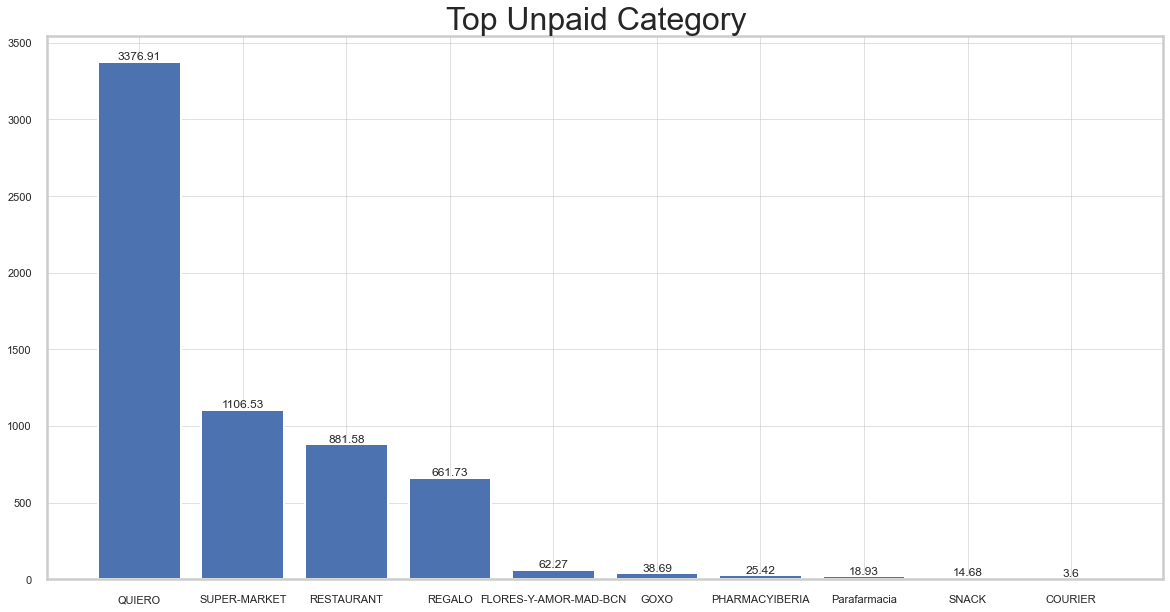

In [475]:
x_data=df5.loc[:,"category"]
y_data=df5.loc[:,"gtv_euro"]



bar = plt.bar(x_data, round(y_data,2))


for a,b in zip(x_data, round(y_data,2)):
    plt.text(a,b,
             b,
             ha='center', 
             va='bottom'
            )
    
_ =plt.title(label = 'Top Unpaid Category  ',
          fontsize = 32)


# Price Change distribution


## Price change count distribution


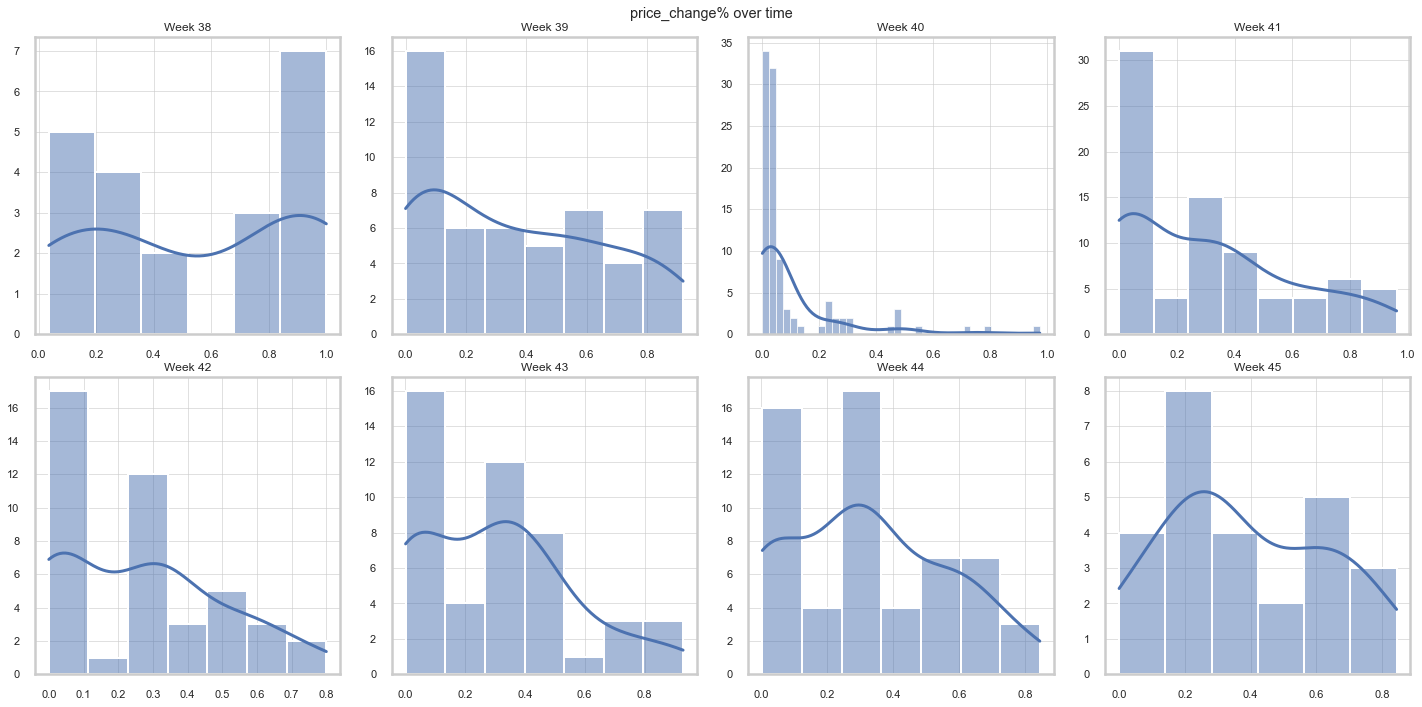

In [476]:

df10=df.loc[(df['price_change%']>=0) & (df['price_change%']<=1)]

fig, axes = plt.subplots(ncols=4, nrows=2,)
fig.suptitle('price_change% over time')
fig.tight_layout()

for i, ax in zip(range(df10['order_week'].max()-7, df10['order_week'].max()+1), axes.flat):
    sns.histplot(df10[df10['order_week'] == i]['price_change%'], ax=ax, kde=True).set(title=f'Week {i}', xlabel=None, ylabel=None)
plt.show()

In [477]:
df10



,index,order_id,customer_id,store_address_id,courier_id,category,vertical,order_day,ordering_payment_method,payment_status,p_payment_status,final_status,is_groceries,purchases_estimated_price,total_purchase_euro,price_difference,balance_discount,gtv,authorization_euros,gtv_euro,account_age_hours,accountageindays,graph_size,cash_score,customer_name,ravelin_score,ravelin_source,ravelin_action,email,phone,account_age_seconds,store_id,delivery_point,pickup_point,appversion,device_model,device_osversion,device_ip,device_os,device_type,bin,cc_country,card_provider,store_category,store_name,order_type,payment_activecount,payment_failedcount,payment_count,paid_orders,orders_30days,foc,card_age,card_age_creation,distinct_countries,spent_30d,spent_90d,refund_30d,refund_90d,order_count_90day,order_count_30day,order_count_7day,delivered_orders,promotion_description,decline_errors,email_domain,price_change%,order_week,order_day_int
11,11,480598634,108136160,362919.0,75116498.0,RESTAURANT,WALL - Partner,2022-09-25,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,148.20,148.20,0.00,0.00,153.68,117.0,153.68,6048.0,252.0,14.0,NaN,Fabio Maroccia,16.0,RULE,REVIEW,fabio.maroccia@libero.it,3.934543e+11,21776055.0,228627.0,8939540a91bffff,89395401a5bffff,5.183.0,samsung sm-a525f,12,37.14.27.137,ANDROID,Mobile,516795.0,IT,MasterCard,1.0,Gonzalez & Co Burrito & Bowl,STORE,1.0,0.0,1.0,3.0,2.0,6.0,6221060.0,1.657914e+12,"[""IT""]",5060.0,7749.0,0.0,0.0,4.0,4.0,NaN,6.0,NaN,{},libero.it,0.313504,38,1664064000000000000
24,24,489029448,133739238,378661.0,NaN,RESTAURANT,WALL - Partner,2022-10-10,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,False,119.60,119.60,0.00,0.00,120.60,120.0,120.60,2.0,0.0,4.0,NaN,Hafed Haguda,96.0,RAVELIN,REVIEW,oussama1980089@icloud.com,3.460098e+10,10485.0,243329.0,89394429893ffff,89394429893ffff,7.83.0,iPhone6S,13.5.1,46.6.187.106,IOS,Mobile,NaN,NaN,NaN,1.0,Sabor Turc,STORE,0.0,0.0,0.0,0.0,5.0,4.0,0.0,1.665416e+12,[],8211.0,8211.0,0.0,0.0,5.0,5.0,NaN,3.0,NaN,{},icloud.com,0.005000,41,1665360000000000000
25,25,489275599,1262436,315367.0,114082854.0,SUPER-MARKET,WALL - Partner,2022-10-11,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,True,122.64,122.64,0.00,3.15,119.49,119.0,119.49,42421.0,1767.0,6.0,NaN,Raul Samper Vergara,27.0,RAVELIN,ALLOW,raulsamper23@gmail.com,3.467208e+10,152717652.0,189886.0,89391c70853ffff,89391c7087bffff,5.185.0,xiaomi m2007j20cg,11,81.36.1.18,ANDROID,Mobile,476664.0,ES,Visa,4.0,Glovo Express,STORE,2.0,0.0,3.0,4.0,15.0,38.0,7207077.0,1.658266e+12,"[null,""ES""]",27206.0,54012.0,0.0,0.0,30.0,30.0,NaN,38.0,NaN,{},gmail.com,0.004118,41,1665446400000000000
29,29,493193910,134185103,458763.0,67189778.0,SUPER-MARKET,WALL - Partner,2022-10-17,APPLE_PAY,NOT_PAID,NOT_PAID,DeliveredStatus,True,109.23,109.23,0.00,0.00,113.32,113.0,113.32,0.0,0.0,NaN,NaN,Daniela Santos,90.0,RAVELIN,REVIEW,danysv@mac.com,NaN,1298.0,113925.0,89390cb1b2fffff,89390ca261bffff,7.84.0,iPhone12Pro_Max,16,88.12.19.223,IOS,Mobile,NaN,NaN,NaN,4.0,Alcampo,STORE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.666024e+12,[],0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,{},mac.com,0.002832,42,1665964800000000000
39,39,497341781,123466243,274584.0,NaN,REGALO,WALL - Partner,2022-10-24,CREDIT_CARD,NOT_PAID,NOT_PAID,DeliveredStatus,False,100.00,100.00,0.00,0.00,100.20,100.0,100.20,3721.0,155.0,6.0,NaN,Felipe Rueda,87.0,RULE,REVIEW,feliperueda91@gmail.com,3.461105e+10,13398667.0,158586.0,8939446004bffff,89394460e43ffff,5.187.0,motorola moto g(9) plus,11,178.197.200.29,ANDROID,Mobile,404700.0,ES,Visa,22.0,Tarjeta Regalo Glovo,STORE,2.0,0.0,2.0,0.0,3.0,2.0,351394.0,1.666288e+12,"[""GB"",""ES""]",4768.0,4768.0,0.0,0.0,3.0,3.0,NaN,2.0,NaN,{},gmail.com,0.002000,43,1666569600000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,518,492435845,115162955

## Price Change Unpaid Amount Distribution

In [478]:
conditions = [
    (df['price_change%'] < 0),
    (df['price_change%'] >= 0) & (df['price_change%'] < 0.2),
    (df['price_change%'] >= 0.2) & (df['price_change%'] < 0.4),
    (df['price_change%'] >= 0.4) & (df['price_change%'] < 0.6),
    (df['price_change%'] >= 0.6) & (df['price_change%'] < 0.8),
    (df['price_change%'] >= 0.8) & (df['price_change%'] < 1),
    (df['price_change%'] >= 1)
    ]

# create a list of the values we want to assign for each condition
values = ['-Negative', '0-20%', '20-40%', '40-60%','60-80%','80-100%','>100%']

# create a new column and use np.select to assign values to it using our lists as arguments
df['change % level'] = np.select(conditions, values)



<AxesSubplot:xlabel='order_week', ylabel='gtv_euro'>

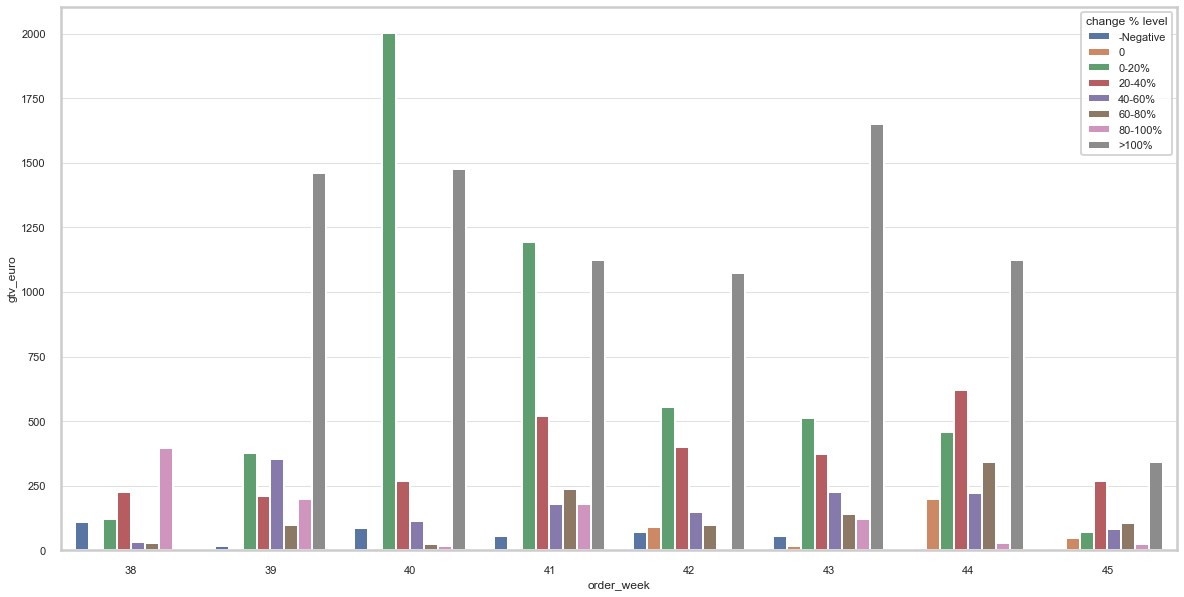

In [479]:
category = df.groupby(['order_week', 'change % level']).sum().reset_index()
sns.barplot(data=category, x='order_week', y='gtv_euro', hue='change % level')